# Data collection and preprocessing 

You will find in this notebook the code to be executed to collect data as reported in section II of the report.

In [1]:
import library_data as data 
import library_plot as plot
import library_stats as stats
import library_stylized_facts as sf
import library_coinapi_data_acquisition as coinapi
from datetime import datetime
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## A. Historical cryptocurrency

You can find all the necessary imports in the notebook `Results.ipynb`.

In [2]:
# ----- INTRADAY DATA ----
path_btc = "data/raw/intraday_historical/BTC_intraday.csv"

path_ltc_mob = "data/raw/binanceus/binanceus_LTCUSD/mob/"
path_ada_mob = "data/raw/binanceus/binanceus_ADAUSD/mob/"
path_eth_mob = "data/raw/bitstamp_ETHUSD/mob/"

path_ltc = "data/raw/intraday_historical/LTC_intraday"
path_ada = "data/raw/intraday_historical/ADA_intraday"
path_eth = "data/raw/intraday_historical/ETH_intraday"

# ---- Creation of 1-min frequency datasets for LTC, ADA, ETH ----
#Retrieve close price on 1-min frequency from mob data
#data.close_price_all(path_ltc_mob, "LTC")
#data.close_price_all(path_ada_mob, "ADA")
#data.close_price_all(path_eth_mob, "ETH")

#Merge data tp get final file
#data.merge_historical_data()

# Load data
df_btc = data.get_btc_intraday(path_btc)
df_ada = pd.read_parquet(path_ada)
df_ltc = pd.read_parquet(path_ltc)
df_eth = pd.read_parquet(path_eth)

# -------- DAILY DATA -------
start = "2018-12-31"
btc_daily = data.get_daily("BTC-USD", start)

There are no NaN values in the dataframe


## B. Google Trends

In [3]:
#Time period of interest for collecting data
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

# ---- Final file for the project - HOURLY DATA ---- 
data.main_google_trends_hourly()

# ----- Demo version - Collecting data via API - DAILY DATA -----
# Files can be found in "data/raw/google_trends/daily/"
#data.main_google_trends_daily(0)

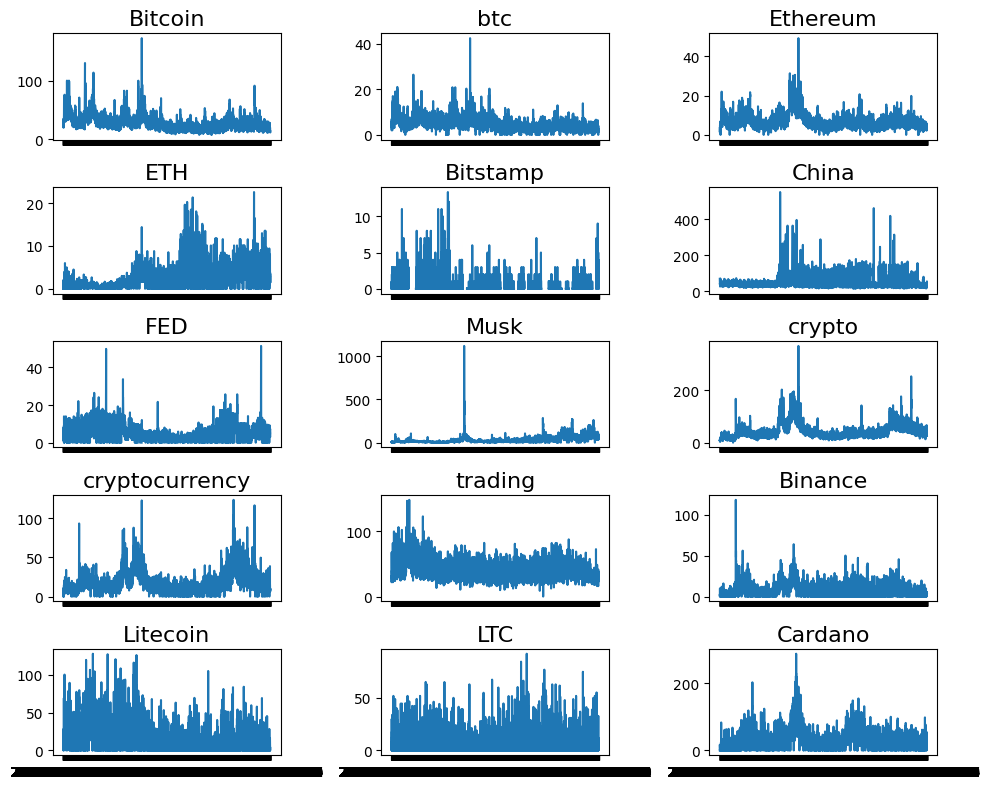

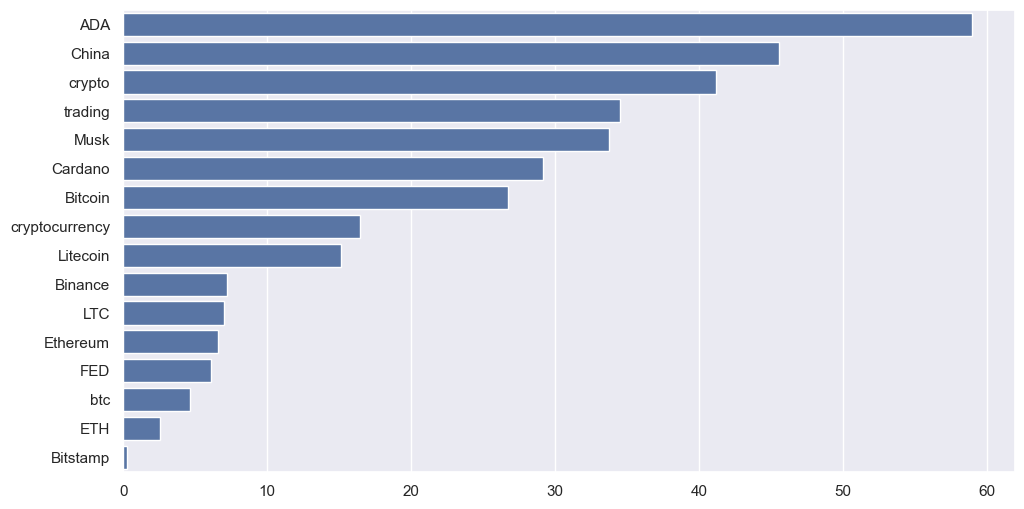

In [4]:
#Retrieve file with all Google Trends (hourly data). 
df = pd.read_parquet('data/raw/google_trends/hourly/merged/all')

#Plot evolution of keywords (takes some time)
#plot.keywords_evolution(df, 5, 3)

#Ranking of keywords by maximum index
plot.rank_keywords_index(df)

In [6]:
# Final dataframe with Google Trends data and historical data 

# ----- Load data -----
cryptos = ['btc', 'ltc', 'ada', 'eth']

kw_df = pd.read_parquet('data/raw/google_trends/hourly/merged/all')

path_btc = "data/raw/intraday_historical/BTC_intraday.csv"
path_ltc = "data/raw/intraday_historical/LTC_intraday"
path_ada = "data/raw/intraday_historical/ADA_intraday"
path_eth = "data/raw/intraday_historical/ETH_intraday"

df_btc = data.get_btc_intraday(path_btc)[["Close"]]
df_ada = pd.read_parquet(path_ada)
df_ltc = pd.read_parquet(path_ltc)
df_eth = pd.read_parquet(path_eth)

start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31, 23, 59)

# ----- Select right timeframe ----- 
for crypto in cryptos : 
    locals()[f'df_{crypto}'] = data.filter_timeframes(start_date, end_date, locals()[f'df_{crypto}'])

# ----- Compute logreturns ----
for crypto in cryptos:
    locals()[f'df_{crypto}'] = sf.logreturns(locals()[f'df_{crypto}'], "Close")[['Logrets']]

# ----- Transform intraday data to hourly data ----
for crypto in cryptos:
    locals()[f'df_{crypto}'] = data.minutes2hours(locals()[f'df_{crypto}'])

# ----- Preprocessing of keywords data ----- 
kw_df = data.proprocessing_keywords(kw_df, start_date, end_date)

# ---- Merge all data into one dataframe ---- 
# File can be found in "data/clean/google_trends/"
data.data_transfer_entropy(df_btc, df_ada, df_eth, df_ltc, kw_df)

There are no NaN values in the dataframe


## C. Data Pre-Processing of Trade Data

In [ ]:
# -----  Data collection (takes several days due to rate restrictions in CoinAPI) ----- 

# Retrieve API key from CoinAPI
def retrieve_api_key(name_file) : 
    api_key = None
    with open(name_file) as file:
        api_key = file.readline().strip()
    return api_key

#In order to reproduce data collection, one must create a CoinAPI key and put it in a file named "CoinAPI_key.txt"
path_file_API = "CoinAPI_key.txt"
for coin in ['BTC','ETH','LTC','ADA']:
    for exchange in ['binanceus','bitstamp']:
        #Collects data week by week

        for i in range(52):
            #Trade data collection:
            coinapi.main_get_historical_trades(path_file_API, "data/periods_API.txt", 0+i*7)
            #Order book data collection:
            coinapi.main_get_historical_mob(path_file_API, "data/periods_API.txt", 0+i*7) 


In [2]:
# -----  Checking data integrity and generate clean log-returns ----- 
raw_data_path = "data/raw/"
output_dir = "data/clean/"

# -----  Preprocessing of full trade and mob data (Uncomment next line and comment the following for loop) ----- 
#for coin, exchange, datatype in [(coin, exchange, datatype) for coin in ['BTC', 'ETH', 'LTC', 'ADA'] for exchange in ['binanceus', 'bitstamp'] for datatype in ['trades', 'mob']]:
# -----  Preprocessing of example data (Uncomment next line) ----- 
for coin, exchange, datatype in [(coin, exchange, datatype) for coin in ['LTC'] for exchange in ['binanceus'] for datatype in ['trades']]:
            # Check that all data was collected correctly
            if coinapi.check_data_integrity(coin, exchange, datatype,raw_data_path):
                #Log returns are saved to a parquet file and returned as a DataFrame
                returns_df = coinapi.generate_returns_df(coin, exchange, datatype, raw_data_path, output_dir)
                print(f"Day : {returns_df['time_exchange'][0][0:10]}. Number of trades : {len(returns_df)+1}, mean log return per trade : {returns_df['log_returns'].mean()}")
            else:
                print(f"{exchange} data for {coin} coin was not downloaded correctly. Please re-run data acquisition.")



Day : 2021-04-14. Number of trades : 24555, mean log return per trade : 1.6919163449351289e-06
